In [1]:
import os ,datetime
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

batch_size = 32
seq_len = 49

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [2]:
" data download  https://finance.yahoo.com/quote/IBM/history?period1=950400&period2=1594512000&interval=1d&filter=history&frequency=1d"

df = pd.read_csv('./input/szzs.csv', delimiter=',', usecols=['Date', 'Close'])



# Apply moving average with a window of 10 days to all columns
df[[ 'Close']] = df[[ 'Close']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 


'''Calculate percentage change'''


df['Close'] = df['Close'].pct_change() # Create arithmetic returns column


df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values


'''Normalize price columns'''

min_return = min(df[['Close']].min(axis=0))
max_return = max(df[['Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)

df['Close'] = (df['Close'] - min_return) / (max_return - min_return)


'''Create training, validation and test split'''
print(df)
times = sorted(df.index.values)
last_30pct = sorted(df.index.values)[-int(0.3*len(times))] # Last 30% of series

df_train = df[(df.index < last_30pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_30pct)]
df_test = df[(df.index >= last_30pct)]
test_tick=df[(df.index >= last_30pct)]['Date'][49:]
# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays

train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 0][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)


            Date     Close
10    1991-01-16  0.214099
11    1991-01-17  0.208917
12    1991-01-18  0.203710
13    1991-01-21  0.201251
14    1991-01-22  0.196765
...          ...       ...
7306  2020-11-24  0.199378
7307  2020-11-25  0.195838
7308  2020-11-26  0.197547
7309  2020-11-27  0.208043
7310  2020-11-30  0.199669

[7301 rows x 2 columns]


D:\Users\pangg\anaconda3\envs\transformer\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
import model
model = model.create_model()
callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding_avg.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)
history = model.fit(X_train, y_train, 
                    batch_size=batch_size,  
                    epochs=30, 
                    steps_per_epoch=len(X_train)/batch_size,
                    callbacks=[callback],
                    validation_data=(X_val, y_val)) 
model.load_weights('Transformer+TimeEmbedding_avg.hdf5')

Train on 5062 samples, validate on 2141 samples
Epoch 1/30
5056/5062 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0451 - mape: 39663.0234
Epoch 00001: val_loss improved from inf to 0.00060, saving model to Transformer+TimeEmbedding_avg.hdf5
5062/5062 [==============================] - 74s 15ms/sample - loss: 0.0050 - mae: 0.0451 - mape: 39616.0273 - val_loss: 5.9631e-04 - val_mae: 0.0174 - val_mape: 9.8806
Epoch 2/30
5056/5062 [============================>.] - ETA: 0s - loss: 0.0025 - mae: 0.0314 - mape: 40054.2070
Epoch 00002: val_loss improved from 0.00060 to 0.00059, saving model to Transformer+TimeEmbedding_avg.hdf5
5062/5062 [==============================] - 47s 9ms/sample - loss: 0.0025 - mae: 0.0314 - mape: 40006.7422 - val_loss: 5.9429e-04 - val_mae: 0.0173 - val_mape: 9.8605
Epoch 3/30
5056/5062 [============================>.] - ETA: 0s - loss: 0.0025 - mae: 0.0313 - mape: 34636.3945
Epoch 00003: val_loss did not improve from 0.00059
5062/5062 [=======

5056/5062 [============================>.] - ETA: 0s - loss: 8.1106e-04 - mae: 0.0175 - mape: 31628.4551
Epoch 00024: val_loss did not improve from 0.00014
5062/5062 [==============================] - 45s 9ms/sample - loss: 8.1108e-04 - mae: 0.0175 - mape: 31590.9766 - val_loss: 1.8098e-04 - val_mae: 0.0104 - val_mape: 5.5910
Epoch 25/30
5056/5062 [============================>.] - ETA: 0s - loss: 7.8138e-04 - mae: 0.0168 - mape: 27164.2559
Epoch 00025: val_loss did not improve from 0.00014
5062/5062 [==============================] - 46s 9ms/sample - loss: 7.8069e-04 - mae: 0.0168 - mape: 27132.0645 - val_loss: 1.9218e-04 - val_mae: 0.0109 - val_mape: 5.8918
Epoch 26/30
5056/5062 [============================>.] - ETA: 0s - loss: 7.6827e-04 - mae: 0.0161 - mape: 22407.6523
Epoch 00026: val_loss improved from 0.00014 to 0.00012, saving model to Transformer+TimeEmbedding_avg.hdf5
5062/5062 [==============================] - 47s 9ms/sample - loss: 7.6817e-04 - mae: 0.0161 - mape: 22381.1

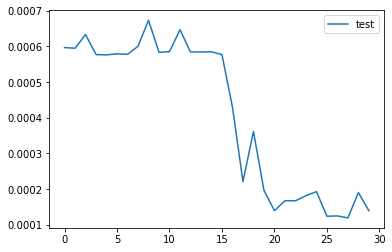

In [17]:
import matplotlib.pyplot as plt
fig=plt.figure()
ax=plt.subplot(111)

ax2=plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

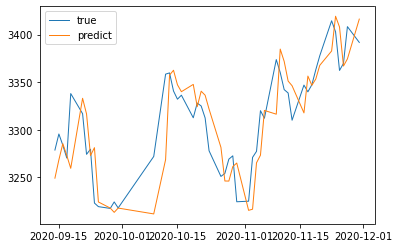

In [22]:
y=model.predict(X_test)
fig=plt.figure()
import datetime

# print(test_tick)
# test_tick=test_tick.apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d'))


true_y=y*(max_return - min_return)+min_return
true_ytest=y_test*(max_return - min_return)+min_return
df = pd.read_csv('./input/szzs.csv', delimiter=',', usecols=['Date','Close'])

real_close=df[(df.index >= last_30pct)]['Close'][48:-1].values
pre_close=[]

for i in range(len(real_close)):
	predict_close=real_close[i]*(1+true_y[i])
	pre_close.append(predict_close)

plt.plot(test_tick[-50:],df[(df.index >= last_30pct)]['Close'][49:].values[-50:],label="true",linewidth=1)
plt.plot(test_tick[-50:],pre_close[-50:],label="predict",linewidth=1)
    
plt.legend()
plt.show()

In [33]:
result_df=pd.DataFrame()
result_df['date']=test_tick
result_df['true']=df[(df.index >= last_30pct)]['Close']
pre_closed=[]
for i in range(len(pre_close)):
    pre_closed.append(pre_close[i][0])
result_df['predict']=pre_closed
result_df.to_csv('close_result.csv')

In [27]:
def RMSE(y1,y2):
    return np.sqrt(np.mean((y1-y2)**2))
def MAE(y1,y2):
    return np.mean(np.abs(y1-y2))
def MAPE(y1,y2):
    return np.mean(np.abs((y1-y2)/y1))*100
def RMSPE(y1,y2):
    return np.sqrt(np.mean(((y1-y2)/y1)**2))*100

In [38]:
loss_result={}
loss_result['rmse']=RMSE(result_df['true'].values,result_df['predict'].values)
loss_result['mae']=MAE(result_df['true'].values,result_df['predict'].values)
loss_result['mape']=MAPE(result_df['true'].values,result_df['predict'].values)
loss_result['rmspe']=RMSPE(result_df['true'].values,result_df['predict'].values)
print(loss_result)


{'rmse': 45.11127776603697, 'mae': 27.590888414164677, 'mape': 0.9385370968762838, 'rmspe': 1.4209645446428687}


In [42]:
loss_epoch=pd.DataFrame(history.history)
loss_epoch.to_csv('./epoch_loss.csv')
print(loss_epoch)

        loss       mae          mape  val_loss   val_mae   val_mape
0   0.004978  0.045097  39616.027344  0.000596  0.017365   9.880606
1   0.002509  0.031418  40006.742188  0.000594  0.017307   9.860505
2   0.002483  0.031303  34595.355469  0.000633  0.017439  10.512489
3   0.002485  0.031179  41256.671875  0.000577  0.016443   9.684011
4   0.002483  0.031154  38796.265625  0.000576  0.016457   9.672719
5   0.002447  0.030886  38621.394531  0.000579  0.016431   9.719605
6   0.002441  0.030744  37900.511719  0.000577  0.016668   9.681122
7   0.002442  0.030784  41450.210938  0.000600  0.017469   9.916084
8   0.002457  0.030806  38655.011719  0.000673  0.018278  11.049236
9   0.002432  0.030788  37614.933594  0.000583  0.016475   9.786697
10  0.002443  0.030935  39016.476562  0.000585  0.016498   9.809278
11  0.002446  0.030859  40123.429688  0.000646  0.017717  10.694695
12  0.002452  0.030685  35833.750000  0.000584  0.016487   9.799478
13  0.002419  0.030301  36330.835938  0.000584  